# Clustering analysis

Cluster analysis or clustering is the task of grouping a set of objects in such a way that objects in the same group (called a cluster) are  similar to each other than to those in other groups or clusters. It is the main task of exploratory data mining, and a common technique for statistical data analysis.

In this task we will use **k-means clustering**, a well known unsupervised learning technique, to cluster users based on their debit card usage. 

The clustering process is a high resource demanding algorithm and we will use the power of **Apache Spark** with a Hadoop File System.

This notebook shows how we used Python to run the algorithm over the previous scaled data set. The process was executed first over the sample data file on a desktop computer. Later, the final application was run in the cluster with the full data set.

## Running the K-means machine learning algorithm 

In the K-Means algorithm process the dataset is partitioned into K clusters and the data points are randomly assigned to the clusters resulting in clusters that have roughly the same number of data points.

For each data point the algorithm calculates the distance from the data point to each cluster. If the data point is closest to its own cluster, leave it where it is. If the data point is not closest to its own cluster, move it into the closest cluster.

This process is repeated until a complete pass through all the data points results in no data point moving from one cluster to another. 

Then the clusters are stable and the clustering process ends.

In [1]:
import pyspark
from pyspark.mllib.clustering import KMeans, KMeansModel
from math import sqrt
from numpy import array
import pandas as pd
import numpy as np
sc = pyspark.SparkContext('local[*]')

In [2]:
# Reading the file and showing the the first line with the PER_ID_PERSONA variable and the other scaled variables
data = sc.textFile('./sample_scaled.csv').map(lambda x: x.strip().split(","))
data.take(2)

[[u'"002JN2ZPCA9DPVUE1Q7P"',
  u'-0.203482835943744',
  u'-0.18567864257164',
  u'-0.239067826339875',
  u'0.407336432210637',
  u'-0.297595479639087',
  u'-0.382228893402316'],
 [u'"0034SFJMXSQT5WX8QXY1"',
  u'2.17540799923321',
  u'-0.18567864257164',
  u'-0.239067826339875',
  u'0.407336432210637',
  u'-0.297595479639087',
  u'-0.382228893402316']]

In [3]:
# Data was wrangled to extract PER_ID_PERSONA
clustering_input_pairs = data.map(lambda x: (x[0], array([float(x[1]), float(x[2]), float(x[3]), float(x[4]), float(x[5]), float(x[6])])))
clustering_input_pairs.take(2)

[(u'"002JN2ZPCA9DPVUE1Q7P"',
  array([-0.20348284, -0.18567864, -0.23906783,  0.40733643, -0.29759548,
         -0.38222889])),
 (u'"0034SFJMXSQT5WX8QXY1"',
  array([ 2.175408  , -0.18567864, -0.23906783,  0.40733643, -0.29759548,
         -0.38222889]))]

In [4]:
# clustering_input contains the variables to be clustered
clustering_input = data.map(lambda x: array([float(x[1]), float(x[2]), float(x[3]), float(x[4]), float(x[5]), float(x[6])]))
clustering_input.take(2)

[array([-0.20348284, -0.18567864, -0.23906783,  0.40733643, -0.29759548,
        -0.38222889]),
 array([ 2.175408  , -0.18567864, -0.23906783,  0.40733643, -0.29759548,
        -0.38222889])]

In [5]:
# This function calculates the sum of squared errors for each point
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

In [19]:
# The algorithm is trained over the dataset for a number of predefined clusters to partition the data.
clustering_error = []
for i in range(2,10):
  clusters = KMeans.train(clustering_input, i, maxIterations=10, initializationMode="random")
  
  WSSSE = clustering_input.map(lambda point: error(point)).reduce(lambda x, y: x + y)
  print("Within Set Sum of Squared Error = " + str(WSSSE))
  clustering_error.append({"clusters":i, "wssse":WSSSE})

Within Set Sum of Squared Error = 47970.4103262
Within Set Sum of Squared Error = 40421.463598
Within Set Sum of Squared Error = 31147.7407155
Within Set Sum of Squared Error = 20649.7720422
Within Set Sum of Squared Error = 19554.0605653
Within Set Sum of Squared Error = 18043.7840358
Within Set Sum of Squared Error = 16614.4501642
Within Set Sum of Squared Error = 14231.7266557


In [20]:
# The Sum of Squared Errors are shown below for each number of clusters:
cluster_error_set = pd.DataFrame(clustering_error)
cluster_error_set

,clusters,wssse
0,2,47970.410326
1,3,40421.463598
2,4,31147.740715
3,5,20649.772042
4,6,19554.060565
5,7,18043.784036
6,8,16614.450164
7,9,14231.726656


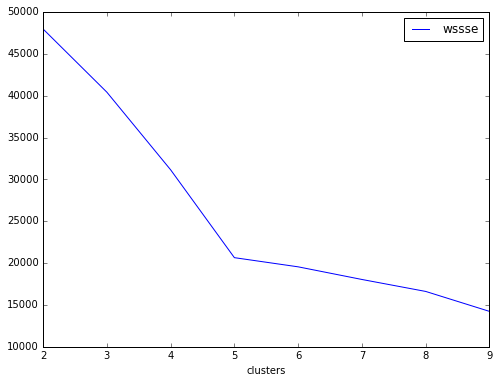

In [21]:
# Plot the Sum of Squared Error. 
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

cluster_error_set.plot(kind="line",x="clusters", y="wssse", figsize=(8,6));

**Chossing the right number of clusters**
The previous plot shows how wssse decreased as the number of clusters increased. The graph suggests that 5 clusters can be a suitable number of cluster to segment the users. We considered that 4 clusters would be more appropriate from a managerial perspective.

In [28]:
# Run the training process again with the number of clusters set to 4
final_clusters = KMeans.train(clustering_input, 4, maxIterations=10, initializationMode="random")

In [29]:
# Assign the cluster membership to each PER_ID_PERSONA
cluster_membership = clustering_input_pairs.mapValues(lambda x: final_clusters.predict(x))
cluster_membership.take(2)

[(u'"002JN2ZPCA9DPVUE1Q7P"', 3), (u'"0034SFJMXSQT5WX8QXY1"', 2)]

In [30]:
# Finally we create a data frame with all the variables, the PER_ID_PERSONA and the assigned cluster
def flatten_cluster_data(r):
    return {"PER_ID_PERSONA": r[0], "cluster" : r[1][0], "F1": r[1][1][0], "F2": r[1][1][1], "F3": r[1][1][2], "F4": r[1][1][3], "F5": r[1][1][4], "F6": r[1][1][5]}
complete_cluster_data = cluster_membership.join(clustering_input_pairs).map(flatten_cluster_data)

In [31]:
cluster_df = pd.DataFrame(complete_cluster_data.collect())
cluster_df[:5]

,F1,F2,F3,F4,F5,F6,PER_ID_PERSONA,cluster
0,-0.516495,-0.185679,-0.239068,0.407336,-0.297595,-0.382229,"""RM7IDNNES0E9YXQDBLNO""",3
1,2.488420,-0.185679,-0.239068,0.407336,-0.297595,-0.382229,"""X5BVS8HJN44LLS9PH6E7""",2
2,0.109529,-0.185679,-0.239068,0.407336,-0.297595,-0.382229,"""UECSYDHEPPDHIA1QDTWO""",3
3,-0.266085,-0.185679,-0.239068,2.622402,-0.297595,-0.382229,"""4J928ECM22BU0SG5BPI1""",3
4,2.488420,-0.185679,-0.239068,0.407336,-0.297595,-0.382229,"""U7ZG3LWHTF5GU903CGH0""",2


### Ploting the clusters

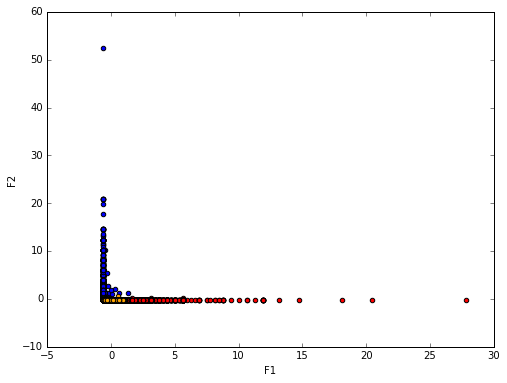

In [32]:
colors = ["Blue", "Green", "Red", "Orange"]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6));
grouped = cluster_df.groupby(['cluster'])
for name, group in grouped:
    group.plot(x="F1",y="F2", kind="scatter", color=colors[name], ax=ax)

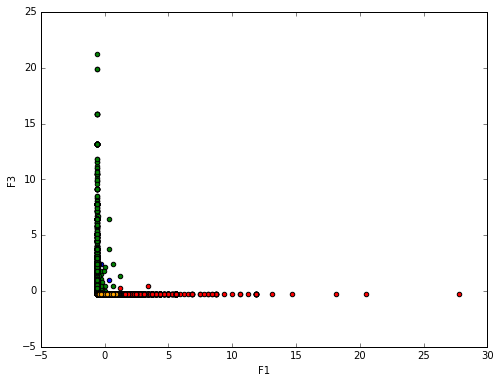

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6));
grouped = cluster_df.groupby(['cluster'])
for name, group in grouped:
    group.plot(x="F1",y="F3", kind="scatter", color=colors[name], ax=ax)

*As a result of the testing phase, a PySpark applications was coded to run the cluestering process over the complete dataset.*